In [ ]:
#' Because of the difference of seeds used in the analysis, 
#' the results could be a little bit different from the results shown in the paper.
#' Despite the difference, the results should get to the same conclusions.

In [1]:
suppressMessages(library(caret))
suppressMessages(library(ggplot2))
suppressMessages(library(randomForest))
suppressMessages(library(pROC))
suppressMessages(library(PRROC))
suppressMessages(library(doParallel))
source("src/cvAUC.R")
options(stringsAsFactors = FALSE)

In [2]:
trainDat = read.table("data/Training_data.txt", sep = "\t")

## Train model and tune parameters
features = list()
features$rf = c("Ubiquitination_2", "Zecha2018_Hela_Halflife", "Length", "Acetylation_1", "Phosphorylation_2")
features$svml = c("Ubiquitination_2", "Mathieson2018_NKs_Halflife", "MLN4924_DMSO.PSI", "Phosphorylation_2")
features$svmr = c("Ubiquitination_2", "Phosphorylation_2", "Mathieson2018_Hepatocytes_Halflife")
features$knn = c("Ubiquitination_2", "Phosphorylation_2", "Zecha2018_Hela_Halflife", "Methylation.K_1", "Sumoylation_1")
features$glm = c("Ubiquitination_2", "MLN4924_DMSO.PSI", "Mathieson2018_NKs_Halflife", "Phosphorylation_2", "MOLT4_RNA")
features$nb = c("Ubiquitination_2", "Zecha2018_Hela_Halflife", "Mathieson2018_NKs_Halflife", "Acetylation_1", "Nterminome")

fitControl <- trainControl(method = "LOOCV", summaryFunction = prSummary)
models = list()
cl <- makePSOCKcluster(2)
registerDoParallel(cl)
#### svm will use more memory (more core will lead to training-out-of-memory) 
message(Sys.time(), " Train the SVM linear ...")
models$svm_linear <- train(x=trainDat[, features$svml], y=trainDat$Degradability, metric = "F",
                           method = "svmLinear", trControl = fitControl, tuneLength = 20)
message(Sys.time(), " Train the SVM Radial ...")
models$svm_radial <- train(x=trainDat[, features$svmr], y=trainDat$Degradability, metric = "F",
                           method = "svmRadial", trControl = fitControl, tuneLength = 20)

cl <- makePSOCKcluster(20)
registerDoParallel(cl)
#### random forest will take more time (more core is recommended) 
message(Sys.time(), " Train the random forest model ...")
models$rf <- train(x=trainDat[, features$rf], y=trainDat$Degradability, method = "rf", metric = "F",
                   ntree = 10000, nodesize = 5, trControl = fitControl, tuneLength = 5)
message(Sys.time(), " Train the logistic regression model ...")
models$logistic <- train(x=trainDat[, features$glm], y=trainDat$Degradability, method = "glm", metric = "F",
                         family = "binomial", trControl = fitControl)
message(Sys.time(), " Train the KNN ...")
models$knn <- train(x=trainDat[, features$knn], y=trainDat$Degradability, method = "knn", metric = "F",
                    trControl = fitControl, tuneLength = 3)
message(Sys.time(), " Train the Naive Bayes ...")
models$naive_bayes <- train(x=trainDat[, features$nb], y=trainDat$Degradability, method = "naive_bayes",
                            metric = "F", trControl = fitControl, tuneLength = 10)

2021-08-07 17:25:50 Train the SVM linear ...

2021-08-07 17:25:55 Train the SVM Radial ...

Warning message in train.default(x = trainDat[, features$svmr], y = trainDat$Degradability, :
“missing values found in aggregated results”
2021-08-07 17:26:36 Train the random forest model ...



note: only 4 unique complexity parameters in default grid. Truncating the grid to 4 .



2021-08-07 17:27:01 Train the logistic regression model ...

2021-08-07 17:27:02 Train the KNN ...

2021-08-07 17:27:03 Train the Naive Bayes ...



In [3]:
# 20-fold cross validation
prList = list()
fold = 20
seed = 19
message(Sys.time(), " random forest model ...")
prList$RF = cvAUC(x=trainDat[, features$rf], y=trainDat$Degradability, models$rf$bestTune, method = "rf", 
                  ntree = 10000, nodesize = 5, fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " regLogistic model ...")
prList$Logistic = cvAUC(x=trainDat[, features$glm], y=trainDat$Degradability, models$logistic$bestTune, 
                        method = "glm", family = "binomial", fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " KNN model ...")
prList$KNN = cvAUC(x=trainDat[, features$knn], y=trainDat$Degradability, models$knn$bestTune, 
                   method = "knn", fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " naive_bayes model ...")
prList$NB = cvAUC(x=trainDat[, features$nb], y=trainDat$Degradability, models$naive_bayes$bestTune, method = "naive_bayes", 
                  fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " svmLinear model ...")
prList$svmLinear = cvAUC(x=trainDat[, features$svml], y=trainDat$Degradability, models$svm_linear$bestTune, method = "svmLinear", 
                   fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " svm_radial model ...")
prList$svmRadial = cvAUC(x=trainDat[, features$svmr], y=trainDat$Degradability, models$svm_radial$bestTune, method = "svmRadial", 
                   fold = fold, metric = "prROC", seed = seed)

2021-08-07 17:27:04 random forest model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:27:25 regLogistic model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:27:33 KNN model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:27:42 naive_bayes model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:27:50 svmLinear model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:27:58 svm_radial model ...

Setting levels: control = high, case = low

Setting direction: controls > cases



In [4]:
# prList = readRDS("data/PR_list.rds")

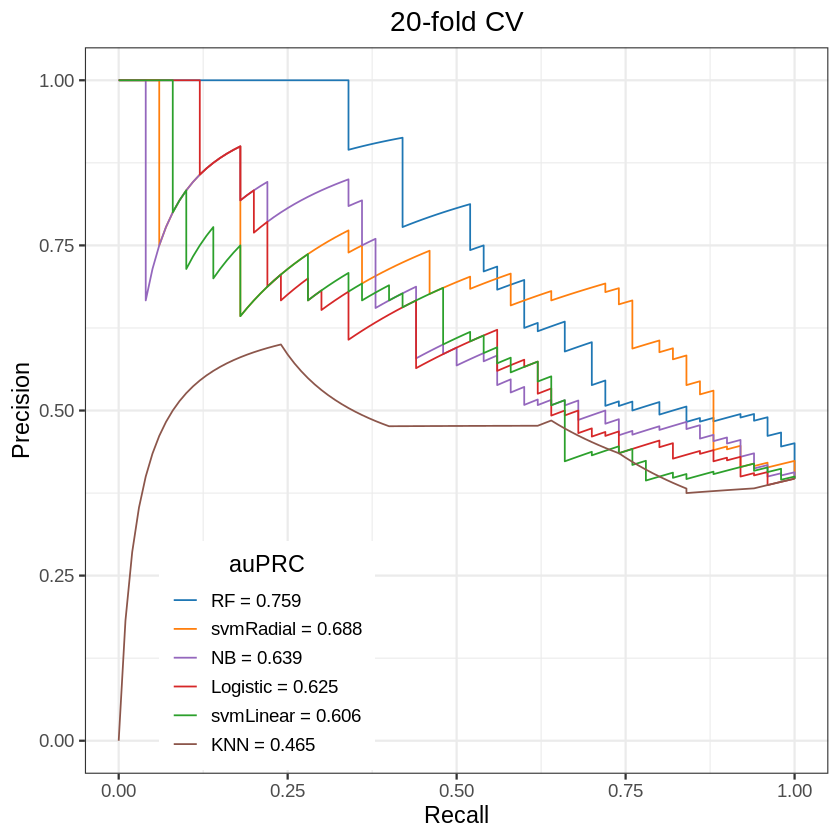

In [5]:
colors = c('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2')
names(colors) = c("RF", "svmRadial", "svmLinear", "Logistic", "NB", "KNN", "Other")
tmp = prList
gg = data.frame()
for(i in 1:length(tmp)){
    tmpCurve = as.data.frame(tmp[[i]]$curve)
    colnames(tmpCurve) = c("Recall", "Precision", "Threshold")
    tmpCurve = tmpCurve[nrow(tmpCurve):1, ]
    tmpCurve$Model = paste0(names(tmp)[i], " = ", round(tmp[[i]]$auc, 3))
    gg = rbind(gg, tmpCurve)
}
ord = order(-as.numeric(gsub(".* ", "", unique(gg$Model))))
gg$Model = factor(gg$Model, levels = unique(gg$Model)[ord])
colors = colors[gsub(" .*", "", unique(gg$Model))]
names(colors) = unique(gg$Model)
p = ggplot(gg, aes(x=Recall, y=Precision, color=Model, group = Model))
p = p + geom_line()
p = p + scale_color_manual(values = colors)
p = p + theme_bw(base_size = 14)
p = p + labs(color = "auPRC", title = "20-fold CV")
p = p + theme(legend.position = c(0.1, 0.005), legend.justification = c("left", "bottom"), 
              legend.title.align = 0.5, plot.title = element_text(hjust = 0.5))
p = p + ylim(0,1)
p

In [6]:
rocList = list()
fold = 20
seed = 3
message(Sys.time(), " random forest model ...")
rocList$RF = cvAUC(x=trainDat[, features$rf], y=trainDat$Degradability, models$rf$bestTune, 
                   method = "rf", ntree = 20000, nodesize = 5, fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " regLogistic model ...")
rocList$Logistic = cvAUC(x=trainDat[, features$glm], y=trainDat$Degradability, models$logistic$bestTune, 
                         method = "glm", fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " KNN model ...")
rocList$KNN = cvAUC(x=trainDat[, features$knn], y=trainDat$Degradability, models$knn$bestTune, 
                    method = "knn", fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " naive_bayes model ...")
rocList$NB = cvAUC(x=trainDat[, features$nb], y=trainDat$Degradability, models$naive_bayes$bestTune, 
                   method = "naive_bayes", fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " svmLinear model ...")
rocList$svmLinear = cvAUC(x=trainDat[, features$svml], y=trainDat$Degradability, models$svm_linear$bestTune, 
                          method = "svmLinear", fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " svm_radial model ...")
rocList$svmRadial = cvAUC(x=trainDat[, features$svmr], y=trainDat$Degradability, models$svm_radial$bestTune, 
                          method = "svmRadial", fold = fold, metric = "auROC", seed = seed)

2021-08-07 17:28:05 random forest model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:28:39 regLogistic model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:28:46 KNN model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:28:54 naive_bayes model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:29:01 svmLinear model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-08-07 17:29:08 svm_radial model ...

Setting levels: control = high, case = low

Setting direction: controls > cases



In [7]:
# rocList = readRDS("data/ROC_list.rds")

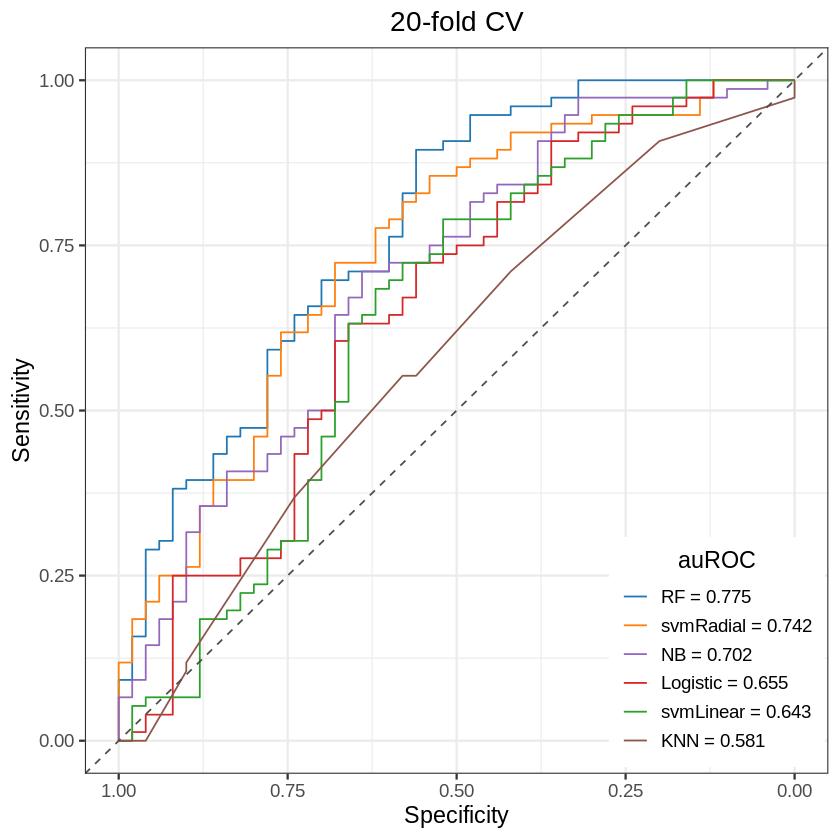

In [8]:
colors = c('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2')
names(colors) = c("RF", "svmRadial", "svmLinear", "Logistic", "NB", "KNN", "Other")
gg = rocList
aucs = unlist(lapply(gg, function(x){ x$auc }))
names(gg) = paste0(names(gg), " = ", round(aucs, 3))
# names(gg) = gsub("RF", "PdTPD RF", names(gg))
gg = gg[order(-aucs)]
colors = colors[gsub(" .*", "", names(gg))]
names(colors) = names(gg)
p = ggroc(gg)
p = p + geom_abline(slope = 1, intercept = 1, color = "gray30", linetype = "dashed")
p = p + scale_color_manual(values = colors)
p = p + theme_bw(base_size = 14)
p = p + labs(color = "auROC", title = "20-fold CV")
p = p + theme(legend.position = c(0.995, 0.01), legend.justification = c("right", "bottom"), 
              legend.title.align = 0.5, plot.title = element_text(hjust = 0.5))
p = p + labs(x = "Specificity", y = "Sensitivity")
p

In [9]:
#### Compare model trained on individual features or the combination of PTM features

In [10]:
featureLists = list(Ubiquitination_2 = c("Ubiquitination_2"),
                    Phosphorylation_2 = "Phosphorylation_2",
                    Hela_Halflife = c("Zecha2018_Hela_Halflife"),
                    Length = c("Length"),
                    PTMs = c("Ubiquitination_2", "Acetylation_1", "Phosphorylation_2"))
cl <- makePSOCKcluster(20)
registerDoParallel(cl)
fitControl <- trainControl(method = "LOOCV")
prLists2 = lapply(featureLists, function(x){
    if(length(x)==1){
        tmpM <- train(x=trainDat[, x,drop=FALSE], y=trainDat$Degradability,
                      trControl = fitControl, method = "glm", family = "binomial")
        rocs = cvAUC(trainDat[, x,drop=FALSE], trainDat$Degradability, tmpM$bestTune, 
                     method = "glm", family = "binomial", metric = "prROC", fold = 20)
        rocs
    }else{
        tmpM <- train(x=trainDat[, x], y=trainDat$Degradability, method = "rf", ntree = 20000, nodesize = 5, 
                      trControl = fitControl, tuneLength = 2)
        rocs = cvAUC(trainDat[, x], trainDat$Degradability, tmpM$bestTune, method = "rf", 
                     ntree = 20000, nodesize = 5, metric = "prROC", fold = 20)
        rocs
    }
})

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases



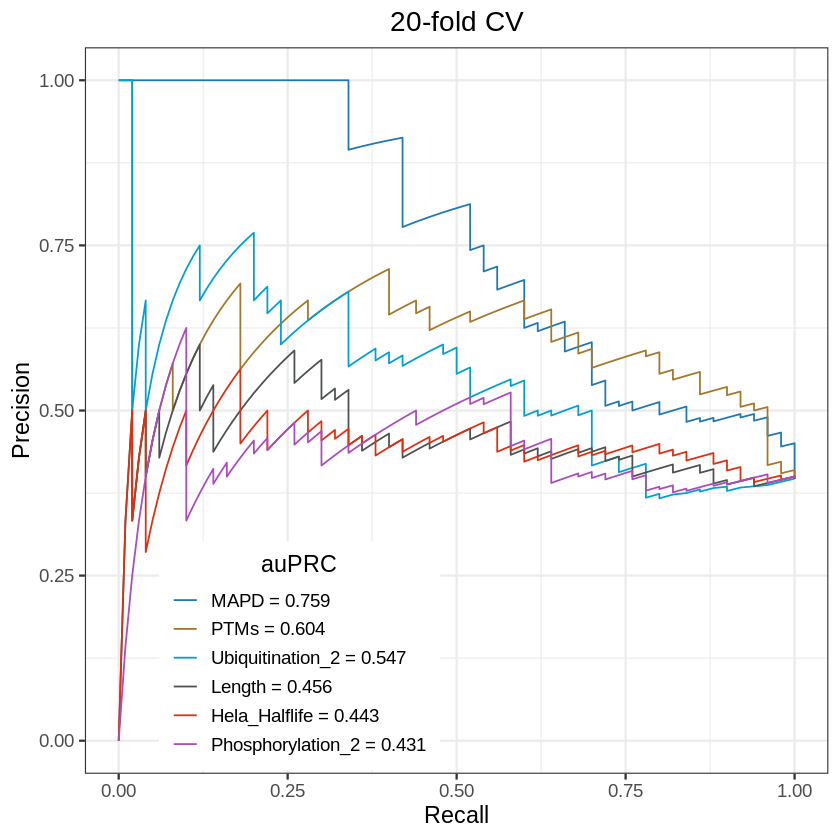

In [11]:
colors = c('#1f77b4', '#00a1d2', '#aa4cbb', '#e02f10', '#4d5250', '#a4772a', '#1b9e77', '#7570b3')[1:6]
tmp = c(MAPD = prList[1], prLists2)
names(tmp) = c("MAPD", "Ubiquitination_2", "Phosphorylation_2", "Hela_Halflife", "Length", "PTMs")
gg = data.frame()
for(i in 1:length(tmp)){
    tmpCurve = as.data.frame(tmp[[i]]$curve)
    colnames(tmpCurve) = c("Recall", "Precision", "Threshold")
    tmpCurve$Model = paste0(names(tmp)[i], " = ", round(tmp[[i]][[2]], 3))
    gg = rbind(gg, tmpCurve)
}
names(colors) = unique(gg$Model)
ord = order(-as.numeric(gsub(".* ", "", unique(gg$Model))))
gg$Model = factor(gg$Model, levels = unique(gg$Model)[ord])
gg = gg[order(gg$Model, -gg$Precision, gg$Recall), ]
colors = colors[unique(gg$Model)]
p = ggplot(gg, aes(x=Recall, y=Precision, color=Model, group = Model))
p = p + geom_line()
p = p + scale_color_manual(values = colors)
p = p + theme_bw(base_size = 14)
p = p + labs(color = "auPRC", title = "20-fold CV")
p = p + theme(legend.position = c(0.1, 0.005), legend.justification = c("left", "bottom"), 
              legend.title.align = 0.5, plot.title = element_text(hjust = 0.5))
p = p + ylim(0,1)
p

In [12]:
featureLists = list(Ubiquitination_2 = c("Ubiquitination_2"),
                    Phosphorylation_2 = "Phosphorylation_2",
                    Hela_Halflife = c("Zecha2018_Hela_Halflife"),
                    Length = c("Length"),
                    PTMs = c("Ubiquitination_2", "Acetylation_1", "Phosphorylation_2"))
fitControl <- trainControl(method = "LOOCV")
cl <- makePSOCKcluster(20)
registerDoParallel(cl)
rocLists2 = lapply(featureLists, function(x){
    if(length(x)==1){
        tmpM <- train(x=trainDat[, x,drop=FALSE], y=trainDat$Degradability, 
                      trControl = fitControl, method = "glm", family = "binomial")
        rocs = cvAUC(trainDat[, x,drop=FALSE], trainDat$Degradability, tmpM$bestTune, 
                     method = "glm", family = "binomial", metric = "auROC", fold = 20)
        return(rocs)
    }else{
        tmpM <- train(x=trainDat[, x], y=trainDat$Degradability, method = "rf", ntree = 20000, nodesize = 5,
                      trControl = fitControl, tuneLength = 2)
        rocs = cvAUC(trainDat[, x], trainDat$Degradability, tmpM$bestTune, method = "rf", ntree = 20000, nodesize = 5,
                  metric = "auROC", fold = 20)
        return(rocs)
    }
})

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases



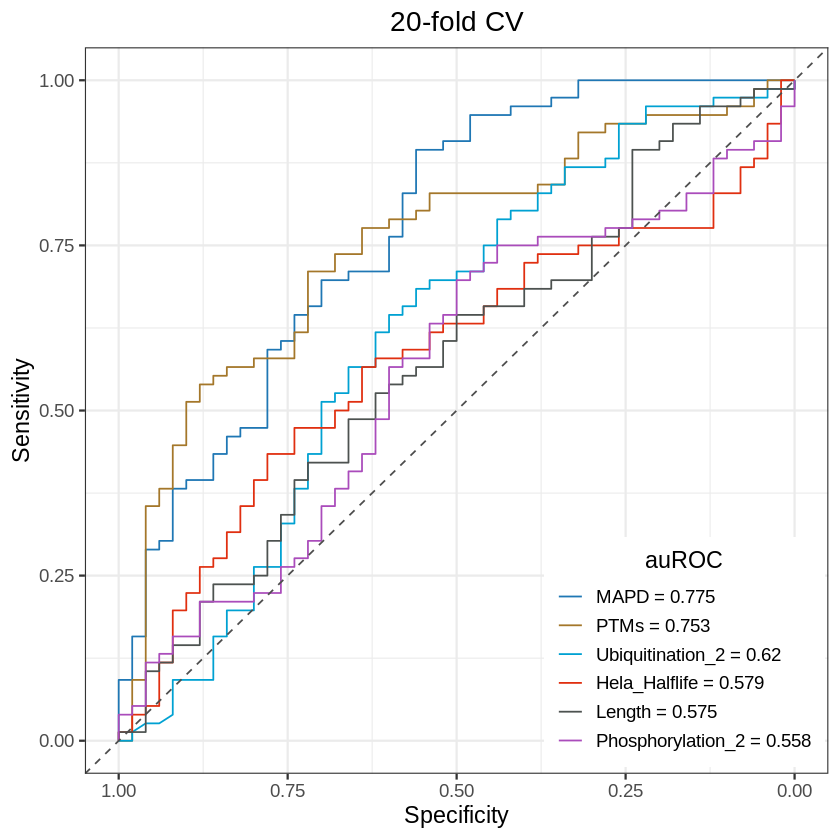

In [13]:
colors = c('#1f77b4', '#00a1d2', '#aa4cbb', '#e02f10', '#4d5250', '#a4772a', '#1b9e77', '#7570b3')[1:6]
gg = c(rocList[1], rocLists2)
names(gg) = c("MAPD", "Ubiquitination_2", "Phosphorylation_2", "Hela_Halflife", "Length", "PTMs")
aucs = unlist(lapply(gg, function(x){ x$auc }))
names(gg) = paste0(names(gg), " = ", round(aucs, 3))
names(colors) = names(gg)
gg = gg[order(-aucs)]
colors = colors[names(gg)]
p = ggroc(gg)
p = p + geom_abline(slope = 1, intercept = 1, color = "gray30", linetype = "dashed")
p = p + scale_color_manual(values = colors)
p = p + theme_bw(base_size = 14)
p = p + labs(color = "auROC", title = "20-fold CV")
p = p + theme(legend.position = c(0.995, 0.01), legend.justification = c("right", "bottom"), 
              legend.title.align = 0.5, plot.title = element_text(hjust = 0.5))
p = p + labs(x = "Specificity", y = "Sensitivity")
p

In [14]:
#### Train the final model

In [15]:
features = c("Ubiquitination_2", "Zecha2018_Hela_Halflife", "Length", "Acetylation_1", "Phosphorylation_2")
trainDat = trainDat[, c("Degradability", features)]
head(trainDat)

,Degradability,Ubiquitination_2,Zecha2018_Hela_Halflife,Length,Acetylation_1,Phosphorylation_2
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
ACVR1B,low,0.04347826,16.961154,505,0.00000000,0.02739726
BRSK1,low,0.00000000,67.245939,778,0.02272727,0.06201550
BRSK2,low,0.00000000,25.200655,736,0.00000000,0.16666667
CAMK1D,low,0.02941176,53.250745,385,0.08823529,0.04166667
CAMK2D,low,0.11111111,62.671535,499,0.08333333,0.24657534
CAMKK2,low,0.19354839,9.713385,588,0.00000000,0.18390805


In [16]:
cl <- makePSOCKcluster(20)
registerDoParallel(cl)

message(Sys.time(), " Train the final model ...")
fitControl <- trainControl(method = "LOOCV", summaryFunction = prSummary, classProbs = TRUE)
final <- train(Degradability~., data = trainDat, method = "rf", ntree = 20000, nodesize = 5,
               importance = TRUE, trControl = fitControl, tuneLength = 5, metric = "F")

stopCluster(cl)

2021-08-07 17:32:26 Train the final model ...



note: only 4 unique complexity parameters in default grid. Truncating the grid to 4 .



In [17]:
testDat = readRDS("data/Features_Imputed.rds")
preds = predict(final, newdata = testDat, type = "prob")
preds = as.data.frame(preds)
rownames(preds) = rownames(testDat)
head(preds)

,high,low
,<dbl>,<dbl>
H3C1,0.81890,0.18110
H3C10,0.81525,0.18475
H3C11,0.80435,0.19565
H3C12,0.80110,0.19890
H3C2,0.81930,0.18070
H3C3,0.80110,0.19890
